In [1]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
mfcc = torch.load('Mfcc_feature.pt')
input=[]
for m in mfcc['mfcc']:
    norm=normalize(m,axis=1)
    input.append(norm)
input=np.asarray(input).transpose(0,2,1)

In [2]:
import tensorflow as tf
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [3]:
embeddingDim=10
timesteps = 400
n_features = 13

In [4]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)




In [5]:
model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=embeddingDim,return_sequences=False),input_shape=(timesteps,n_features)),
    tf.keras.layers.RepeatVector(timesteps),
    tf.keras.layers.LSTM(embeddingDim,activation='relu',return_sequences=True),
    # SeqSelfAttention(embeddingDim,attention_activation='sigmoid',return_attention=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))
    ])


model_tf.compile(optimizer='adam',
              loss=tf.losses.mean_squared_error,
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
model_tf.build(input.shape)
model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20)                1920      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 400, 20)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 10)           1240      
_________________________________________________________________
time_distributed (TimeDistri (None, 400, 13)           143       
Total params: 3,303
Trainable params: 3,303
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_tf.save_weights(checkpoint_path.format(epoch=0))

In [8]:
model_tf.fit(input,input,epochs=1000,callbacks=[cp_callback])

=======] - 1s 47ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 821/1000
20/20 [==============================] - 1s 46ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 822/1000
20/20 [==============================] - 1s 40ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 823/1000
20/20 [==============================] - 1s 41ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 824/1000
20/20 [==============================] - 1s 41ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 825/1000

Epoch 00825: saving model to training_2/cp-0825.ckpt
20/20 [==============================] - 1s 45ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 826/1000
20/20 [==============================] - 1s 45ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 827/1000
20/20 [==============================] - 1s 41ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 828/1000
20/20 [==============================] - 1s 36ms/sample - loss: 0.0025 - acc: 0.0095
Epoch 829/1000
20/20 [==============================] - 1s 44ms/sample - loss: 0.0025 - acc

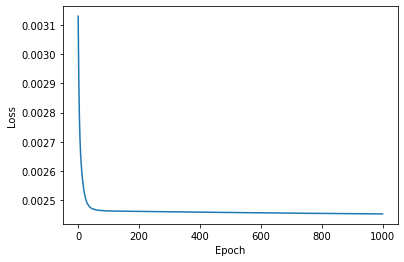

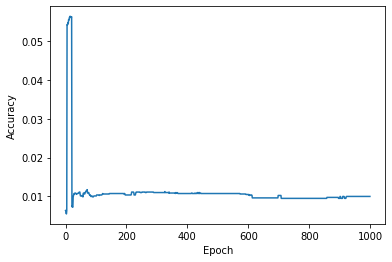

In [9]:
import matplotlib.pyplot as plt
plt.plot(model_tf.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.plot(model_tf.history.history['acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [10]:
model_tf.save(filepath='./Skipgram_using_tf')

# Learning the Embedding

### just the encoder

In [11]:
out=model_tf.predict(input[0][np.newaxis, :])

In [12]:
out

array([[[-0.01435954,  0.01100577,  0.00719938, ...,  0.00773655,
         -0.00074801,  0.00804759],
        [-0.01498258,  0.01265457,  0.00502909, ...,  0.01041794,
         -0.00061581,  0.01039519],
        [-0.01537625,  0.01369639,  0.00365778, ...,  0.01211221,
         -0.00053227,  0.01187855],
        ...,
        [-0.01605606,  0.01549542,  0.00128976, ...,  0.01503791,
         -0.00038802,  0.01444005],
        [-0.01605606,  0.01549542,  0.00128976, ...,  0.01503791,
         -0.00038802,  0.01444005],
        [-0.01605606,  0.01549542,  0.00128976, ...,  0.01503791,
         -0.00038802,  0.01444005]]], dtype=float32)

In [13]:

modelEnc = tf.keras.models.Model(inputs=model_tf.inputs, outputs=model_tf.layers[0].output)
modelEnc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_input (InputLa [(None, 400, 13)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1920      
Total params: 1,920
Trainable params: 1,920
Non-trainable params: 0
_________________________________________________________________


In [14]:
Embedding=modelEnc.predict(input[0][np.newaxis, :])

In [15]:
print('Embedding')
print(Embedding)

Embedding
[[ 0.00312181 -0.01450405  0.03401016 -0.00798813 -0.03545857  0.00989509
  -0.01603872  0.03446159  0.01955161  0.00907986  0.05130916  0.12288968
   0.09109562  0.10942696 -0.08761641  0.11704387  0.22678286 -0.05697407
   0.10369386 -0.04144323]]


In [27]:
def generate_training_data(tokens, window_size,mfcc):
    N = len(tokens)
    X, Y = [], []
    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(normalize(mfcc[i],axis=1))
            Y.append(normalize(mfcc[j],axis=1))     
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [35]:
X, Y = generate_training_data(mfcc['texts'], 3,mfcc['mfcc'])

In [37]:
X.shape

(108, 13, 400)

In [38]:
X=np.asarray(X).transpose(0,2,1)
Y=np.asarray(Y).transpose(0,2,1)

In [40]:
model_tf1 = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=embeddingDim,return_sequences=False),input_shape=(timesteps,n_features)),
    tf.keras.layers.RepeatVector(timesteps),
    tf.keras.layers.LSTM(embeddingDim,activation='relu',return_sequences=True),
    # SeqSelfAttention(embeddingDim,attention_activation='sigmoid',return_attention=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))
    ])


model_tf1.compile(optimizer='adam',
              loss=tf.losses.mean_squared_error,
              metrics=['accuracy'])

In [41]:
# model_tf._clear_losses()
hist=model_tf1.fit(X ,Y, epochs=10, verbose=1)

Epoch 1/10
108/108 [==============================] - 6s 56ms/sample - loss: 0.0037 - acc: 0.1137
Epoch 2/10
108/108 [==============================] - 4s 35ms/sample - loss: 0.0031 - acc: 0.1060
Epoch 3/10
108/108 [==============================] - 3s 31ms/sample - loss: 0.0028 - acc: 0.0472
Epoch 4/10
108/108 [==============================] - 3s 32ms/sample - loss: 0.0026 - acc: 0.0471
Epoch 5/10
108/108 [==============================] - 3s 32ms/sample - loss: 0.0026 - acc: 0.0473
Epoch 6/10
108/108 [==============================] - 3s 31ms/sample - loss: 0.0026 - acc: 0.0469
Epoch 7/10
108/108 [==============================] - 4s 33ms/sample - loss: 0.0025 - acc: 0.0312
Epoch 8/10
108/108 [==============================] - 4s 33ms/sample - loss: 0.0025 - acc: 0.0061
Epoch 9/10
108/108 [==============================] - 4s 34ms/sample - loss: 0.0025 - acc: 0.0076
Epoch 10/10
108/108 [==============================] - 4s 33ms/sample - loss: 0.0025 - acc: 0.0094


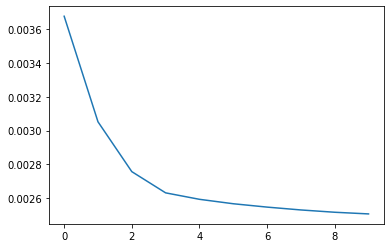

In [42]:
plt.plot(hist.history['loss'])

In [56]:
modelEnc = tf.keras.models.Model(inputs=model_tf1.inputs, outputs=model_tf1.layers[0].output)
Embedding1=modelEnc.predict(X[0][np.newaxis, :])[0]
Embedding2=modelEnc.predict(X[1][np.newaxis, :])[0]
Embedding3=modelEnc.predict(X[2][np.newaxis, :])[0]
Embedding4=modelEnc.predict(X[3][np.newaxis, :])[0]

In [57]:
Embeddings=np.asarray([Embedding1,Embedding2,Embedding3,Embedding4])
words=['label1','label2','label3','label4']

In [59]:
def embeddingPlotTSNE(X,words):
    import numpy as np
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2).fit_transform(X)
    X_embedded.shape
    for word in range(len(words)):
        x, y = X_embedded[word][0],X_embedded[word][1]
        plt.scatter(x, y, marker='.', color='red')
        plt.text(x+10, y+1, words[word], fontsize=9)
        plt.title('t-SNE projection of the word embeddings')
    plt.show()


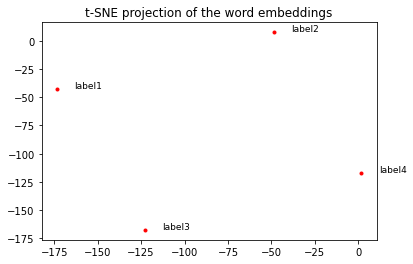

In [60]:
embeddingPlotTSNE(Embeddings,words)